# Raw Data Size Calculator

The following notebook provides a model to calculates the data volume from R1.TEL.EVT and DL0.TEL.EVT data. So far no other technical data  (MON or SVC for example) are included.

Karl Kosack <karl.kosack@cea.fr>



In [3]:
%pylab inline
from astropy import units as u
import pandas as pd
from copy import copy
from ipywidgets import interact

Populating the interactive namespace from numpy and matplotlib


## Assumptions for each Subarray:

average trigger rates per subarray are from https://jama.cta-observatory.org/perspective.req#/items/27987?projectId=6

This assumes CTA-South, without any staging

In [4]:
subarrays = {}

subarrays['LST'] = dict(
    n_pix = 1855,
    rate = 15000 * u.Hz,
    mean_tels_triggered = 2,
)

subarrays['MST'] = dict(
    n_pix = 1855,
    rate = 7000 * u.Hz,
    mean_tels_triggered = 7,
)

subarrays['SST'] = dict(
    n_pix = 2048,
    rate = 600 * u.Hz,
    mean_tels_triggered = 7,
)

obs_per_year = 1200 * u.h
obs_per_night_peak = 12*u.h

pd.DataFrame(subarrays)

,LST,MST,SST
mean_tels_triggered,2,7,7
n_pix,1855,1855,2048
rate,15000.0 Hz,7000.0 Hz,600.0 Hz


we also assume
* we only transfer data when data are not being taken (maybe this is not needed, but the difference is small)
* we should only use at most 70% of the off-site link (which is 1Gbps)

Transfer Rates:
* the mean transfer rate assumes an average over all non-data-taking time in a year
* the peak transfer rate is calcualted for a single long night of 12h of observations, and assumes continuous copying (even during data taking)

## Calculation

In [14]:
def subarray_rate(subarray, 
                  event_id_size=64*u.bit, 
                  timestamp_size=2*32*u.bit, 
                  trig_type_size=8*u.bit, 
                  pix_info_per_pix=8*u.bit, 
                  dvr_percent=3.0,
                  sample_size=16*u.bit,
                  compression_ratio=4.0,
                  num_gain_channels=1,
                 n_samp=64):
    
    dvr_fraction = dvr_percent/100.0
    core_size = event_id_size + timestamp_size + trig_type_size 
    pix_flag_size = pix_info_per_pix * subarray['n_pix']
    
    # images with + without DVR:
    image_size = sample_size * subarray['n_pix'] * n_samp * dvr_fraction
    image_size += sample_size * subarray['n_pix'] * (1.0 - dvr_fraction) # integrated pixels
    image_size *= num_gain_channels

    event_size =  core_size + pix_flag_size + image_size
    
    data_rate = (event_size 
                 * subarray['rate'] 
                 * subarray['mean_tels_triggered']) / compression_ratio 
    
    return data_rate

def combined_data_rate(subarrays, **params):
    """ rate for all subarrays summed """
    rates = [subarray_rate(x, **params).to('Gbit/s').value for x in subarrays.values()]
    return np.sum(rates) * u.Gb/u.s

def colorizer(val):
    """ warn if the off-site link is saturated """
    if val < 0.5:
        color = 'green'
    elif val > 0.5 and val < 0.7:
        color = 'orange'
    elif val > 0.7:
        color = 'red'
    return 'color: %s; font-weight:bold' % color




In [15]:
def calc_rates(subarrays, **params):
    results = pd.DataFrame( index=list(subarrays.keys()))
    results['rate_R1_Gbps'] = [subarray_rate(x, compression_ratio=1, dvr_percent=100).to('Gbit/s').value for x in subarrays.values()]
    results['rate_DL0_Gbps'] = [subarray_rate(x, **params).to('Gbit/s').value for x in subarrays.values()]
    results['volume_1yr_PB'] = (results['rate_DL0_Gbps'].data * u.Gbit/u.s * obs_per_year).to('PB')
    results['volume_5yr_PB'] = (results['rate_DL0_Gbps'].data * u.Gbit/u.s * 5 * obs_per_year).to('PB')
    results['volume_10yr_PB'] = (results['rate_DL0_Gbps'].data * u.Gbit/u.s * 10* obs_per_year).to('PB')
    results['mean_transfer_Gbps'] = (results['volume_1yr_PB'].data *u.PB / (1.0*u.yr - obs_per_year)).to('Gbit/s')
    results['peak_transfer_Gbps'] = (((results['rate_DL0_Gbps'].data * u.Gbit/u.s) * obs_per_night_peak) / (24*u.h)).to('Gbit/s')
    results.loc['TOTAL'] = results.sum()
    return results.style.applymap(colorizer, subset=['mean_transfer_Gbps','peak_transfer_Gbps'])

## Results

### base scenario

In [16]:
results = calc_rates(subarrays)
results

,rate_R1_Gbps,rate_DL0_Gbps,volume_1yr_PB,volume_5yr_PB,volume_10yr_PB,mean_transfer_Gbps,peak_transfer_Gbps
LST,57.4349,0.755634,0.408042,2.04021,4.08042,0.119847,0.377817
MST,93.8103,1.2342,0.666469,3.33235,6.66469,0.19575,0.617101
SST,8.87742,0.11678,0.0630615,0.315307,0.630615,0.0185219,0.0583902
TOTAL,160.123,2.10662,1.13757,5.68787,11.3757,0.334118,1.05331


note all rates are in *Gbit/s* and the **CTA max transfer rate off-site is 1 Gb/s**, so the *mean_transfer_Gbps* column should be $< 1 Gbit/s$

### Scenario 2: increase DVR fraction to keep 10% of pixels

what if we keep 10% of the camera after DVR, instead of the default 3% of pixels?

In [17]:
calc_rates(subarrays, dvr_percent=10.0) 

,rate_R1_Gbps,rate_DL0_Gbps,volume_1yr_PB,volume_5yr_PB,volume_10yr_PB,mean_transfer_Gbps,peak_transfer_Gbps
LST,57.4349,1.7373,0.938142,4.69071,9.38142,0.275543,0.86865
MST,93.8103,2.83759,1.5323,7.66149,15.323,0.450054,1.4188
SST,8.87742,0.268513,0.144997,0.724984,1.44997,0.0425873,0.134256
TOTAL,160.123,4.8434,2.61544,13.0772,26.1544,0.768184,2.4217


here, we exceed the transfer rate (over 75% of the link must be used in non-data-taking time), so this is not a reasonable solution

### Scenario 3: Read out 2 gain channels

Let's try another scenario: assume that the telescopes read out *both gain channels* (in which case we can also probably remove the `pix_info_per_pix` field, since we can compute the gain channel, etc from the raw data

In [18]:
calc_rates(subarrays, num_gain_channels=2, pix_info_per_pix=0*u.bit)

,rate_R1_Gbps,rate_DL0_Gbps,volume_1yr_PB,volume_5yr_PB,volume_10yr_PB,mean_transfer_Gbps,peak_transfer_Gbps
LST,57.4349,1.28765,0.69533,3.47665,6.9533,0.204226,0.643824
MST,93.8103,2.10316,1.13571,5.67853,11.3571,0.33357,1.05158
SST,8.87742,0.199012,0.107466,0.537332,1.07466,0.0315641,0.0995059
TOTAL,160.123,3.58982,1.9385,9.69251,19.385,0.569361,1.79491


The result is that we are nearing the danger level of the link transfer speed (over half of the capacity used for just raw camera data), and the peak transfer is nearly 2x the requirement

## Interactive Exploration

use the code below (running in a real Jupyter notebook, not NBViewer) to have an interactive widget version to try out other scenarios in realtime.

In [20]:
@interact(dvr_percent=(0.0,100.0,1), compression_ratio=(1,4,0.1), pix_info_per_pix=[0*u.bit, 8*u.bit, 16*u.bit],
          num_gain_channels=[1,2], n_samp=(0,128,1))
def explore(dvr_percent=3.0, compression_ratio=3, pix_info_per_pix=8*u.bit, num_gain_channels=1, n_samp=64):
    return calc_rates(subarrays, dvr_percent=dvr_percent, compression_ratio=compression_ratio,
                      pix_info_per_pix=pix_info_per_pix, num_gain_channels=num_gain_channels, n_samp=n_samp)

interactive(children=(FloatSlider(value=3.0, description='dvr_percent', step=1.0), FloatSlider(value=3.0, description='compression_ratio', max=4.0, min=1.0), Dropdown(description='pix_info_per_pix', index=1, options=(<Quantity 0.0 bit>, <Quantity 8.0 bit>, <Quantity 16.0 bit>), value=<Quantity 8.0 bit>), Dropdown(description='num_gain_channels', options=(1, 2), value=1), IntSlider(value=64, description='n_samp', max=128), Output()), _dom_classes=('widget-interact',))

## What about the DL0.SUB.EVT (central trigger) data?

does it respresent a large fraction?

In [21]:
system_trigger_rate = 15_000 *u.Hz
trigger_pattern = 128*u.bit 
timestamp_size = 64*u.bit

dl0_sub_evt_rate = system_trigger_rate * (trigger_pattern + timestamp_size)
dl0_sub_evt_rate.to("Gbit/s")

<Quantity 0.00288 Gbit / s>

this is a small fraction of the DL0 size:

In [22]:
dl0_sub_evt_frac = (dl0_sub_evt_rate/combined_data_rate(subarrays)).to(u.dimensionless_unscaled)
dl0_sub_evt_frac * 100 * u.percent

<Quantity 0.13671210360520186 %>

In [23]:
(3*u.PB/u.yr * dl0_sub_evt_frac).to("TB/yr")

<Quantity 4.101363108156056 Tbyte / yr>

So we should add about this amount to the final data estimate to include the subarray event data

## Some useful parameter space plots

In [29]:
# a hack to get just the final value (this is not very speed friendly!)
@np.vectorize
def transfer_rate(**params):
    df = calc_rates(subarrays, **params)
    return df.data.loc['TOTAL']['mean_transfer_Gbps'], df.data.loc['TOTAL']['peak_transfer_Gbps']

In [30]:
n_samp = np.linspace(0,128,32)
dvr_percent = np.linspace(0,50,21)
N,D = np.meshgrid(n_samp, dvr_percent)

In [49]:
def plot_scenario(name, Rm, Rp):
    figure(figsize=(10,5), dpi=100)

    subplot(1,2,1)

    xlabel("Mean percent pixels with waveform")
    ylabel("$N_{samp}$ read out")
    cs = contour(D, N, Rm, levels=[0.5, 0.75,1,2,5], colors=['green','orange','red', 'red','red'])
    clabel(cs, cs.levels, labels=["{} Gb/s".format(x) for x in cs.levels])
    grid(True)
    title("DL0 transfer rate (mean), Gbit/s")

    subplot(1,2,2)

    xlabel("Mean percent pixels with waveform")
    ylabel("$N_{samp}$ read out")
    cs = contour(D, N, Rp, levels=[0.5, 0.75,1,2,5], colors=['green','orange','red', 'red','red'])
    clabel(cs, cs.levels, labels=["{} Gb/s".format(x) for x in cs.levels])
    grid(True)
    title("DL0 transfer rate (peak), Gbit/s")

    suptitle(name)
    #plt.tight_layout()

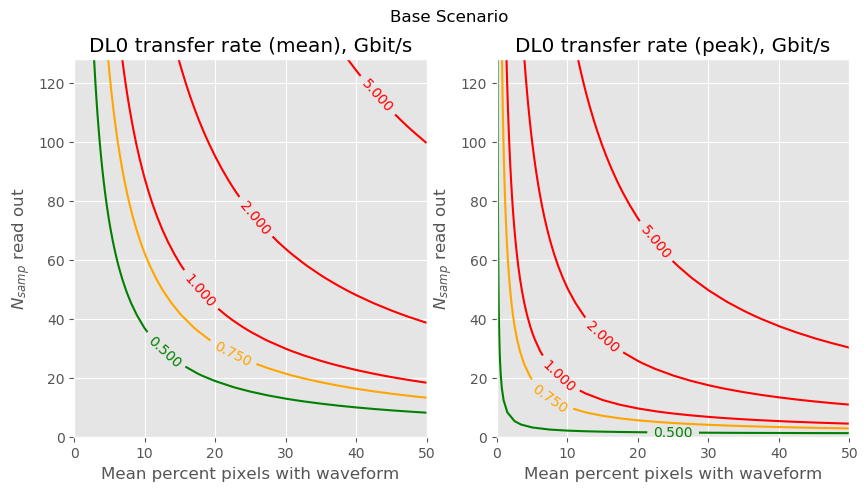

In [50]:
plt.style.use("ggplot")
Rm,Rp = transfer_rate(dvr_percent=D, n_samp=N )
plot_scenario("Base Scenario", Rm, Rp)

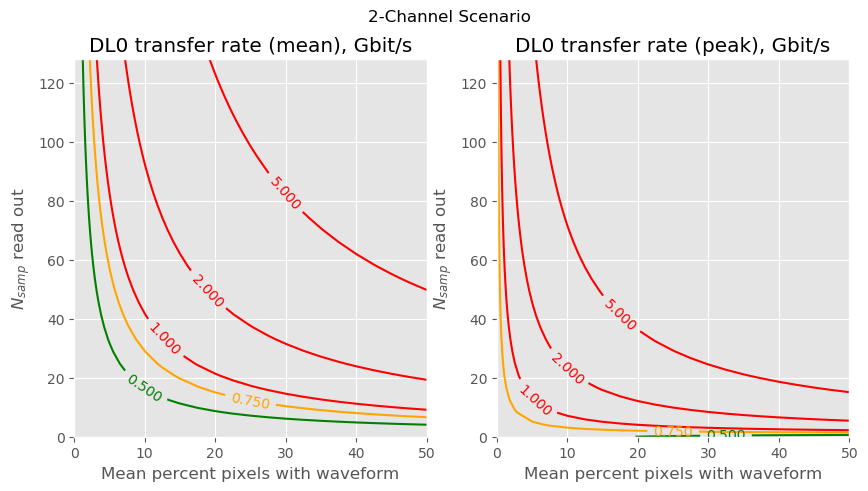

In [51]:
Rm,Rp = transfer_rate(dvr_percent=D, n_samp=N, num_gain_channels=2, pix_info_per_pix=0 )
plot_scenario("2-Channel Scenario", Rm, Rp)